In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install mediapipe

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Parameters
DATASET_PATH = "/content/drive/MyDrive/video_1"
NUM_FRAMES = 30          # fixed number of frames per video
FEATURE_SIZE = 33 * 4    # 33 landmarks, each has (x,y,z,visibility)


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


In [ ]:
# MEDIAPIPE INITIALIZATION
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
# Limb pairs (MediaPipe POSE_CONNECTIONS)
LIMB_PAIRS = list(mp_pose.POSE_CONNECTIONS)
NUM_LIMBS = len(LIMB_PAIRS)

# FEATURE EXTRACTION
def extract_pose_keypoints(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)

    keypoints_list = []

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            landmarks = [0.0] * FEATURE_SIZE

        keypoints_list.append(landmarks)

        if len(keypoints_list) == num_frames:
            break

    cap.release()

    # Pad if not enough frames
    while len(keypoints_list) < num_frames:
        keypoints_list.append([0.0] * FEATURE_SIZE)

    return np.array(keypoints_list)  # shape (NUM_FRAMES, 132)



# LOAD DATASET
def load_subject_data_pose(subject_path, label_map={"ADL": 0, "Fall": 1}):
    X, y = [], []
    for activity in ["ADL", "Fall"]:
        activity_path = os.path.join(subject_path, activity)
        if not os.path.exists(activity_path):
            continue

        for file in os.listdir(activity_path):
            if file.endswith((".avi", ".mp4")):
                video_path = os.path.join(activity_path, file)
                keypoints = extract_pose_keypoints(video_path)
                X.append(keypoints)
                y.append(label_map[activity])

    return np.array(X), np.array(y)


def load_all_subjects_pose(dataset_path=DATASET_PATH):
    all_X, all_y = [], []
    for subject in os.listdir(dataset_path):
        subject_path = os.path.join(dataset_path, subject)
        if os.path.isdir(subject_path):
            print(f"Processing {subject}...")
            X, y = load_subject_data_pose(subject_path)
            all_X.append(X)
            all_y.append(y)

    return np.vstack(all_X), np.hstack(all_y)


# SHUFFLE DATASET
import random
dataset = []
label_map = {"ADL": 0, "Fall": 1}

for subject in os.listdir(DATASET_PATH):
    subject_path = os.path.join(DATASET_PATH, subject)
    if os.path.isdir(subject_path):
        for activity in ["ADL", "Fall"]:
            activity_path = os.path.join(subject_path, activity)
            if os.path.exists(activity_path):
                for file in os.listdir(activity_path):
                    if file.endswith((".avi", ".mp4")):
                        video_path = os.path.join(activity_path, file)
                        dataset.append((video_path, label_map[activity]))

random.shuffle(dataset)
print(f"Total videos in dataset: {len(dataset)}")

Total videos in dataset: 160


In [ ]:
X, y = load_all_subjects_pose(DATASET_PATH)


Processing Subject 1...
Processing Subject 2...
Processing Subject 3...
Processing Subject 4...


In [ ]:
from sklearn.model_selection import train_test_split

X_flat = X.reshape(X.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)


In [ ]:
#  SVM MODEL
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Flatten sequences
X_pose_flat = X_pose.reshape(len(X_pose), -1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_pose_flat, y_pose, test_size=0.2, random_state=42, stratify=y_pose
)

# Define & Train SVM model
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train, y_train)

# Evaluate
y_pred = svm_model.predict(X_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.88      0.88      0.88        16

    accuracy                           0.88        32
   macro avg       0.88      0.88      0.88        32
weighted avg       0.88      0.88      0.88        32

Confusion Matrix:
 [[14  2]
 [ 2 14]]


In [ ]:
# XGBOOST MODEL WITH METRICS
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, accuracy_score
)
import matplotlib.pyplot as plt

# Initialize model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"   # For binary classification
)

# Fit the model with evaluation history
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:47:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.88      0.94      0.91        16

    accuracy                           0.91        32
   macro avg       0.91      0.91      0.91        32
weighted avg       0.91      0.91      0.91        32

Confusion Matrix:
 [[14  2]
 [ 1 15]]
Accuracy: 0.90625


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.5743 - loss: 1.1803 - val_accuracy: 0.6923 - val_loss: 0.5605
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5863 - loss: 1.0574 - val_accuracy: 0.8462 - val_loss: 0.4764
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6378 - loss: 0.9434 - val_accuracy: 0.5000 - val_loss: 1.2146
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6815 - loss: 0.9404 - val_accuracy: 0.7692 - val_loss: 0.4457
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7798 - loss: 0.4655 - val_accuracy: 0.7308 - val_loss: 0.4819
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7835 - loss: 0.5566 - val_accuracy: 0.7308 - val_loss: 0.5948
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7501 - loss: 0.4610 - val_accuracy: 0.6923 - val_loss: 0.5618
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8411 - loss: 0.3503 - val_accuracy: 0.8077 - val_loss: 0.4414

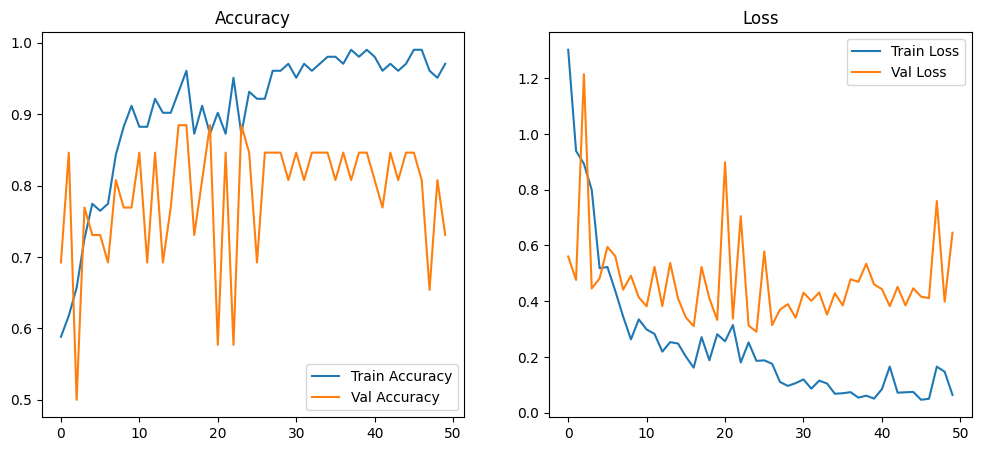

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Define ANN model
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')  # ✅ fixed line
])

# Compile model
ann_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train model
history_ann = ann_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
y_pred = np.argmax(ann_model.predict(X_test), axis=1)
print("ANN Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split # Added import for completeness

# Train/Test Split
X_train_seq, X_test_seq, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Model Definition and Training
print("Training LSTM Model ")
lstm = Sequential([
    # Masking handles the zero-padding from the feature extraction step
    Masking(mask_value=0.0, input_shape=(NUM_FRAMES, FEATURE_SIZE)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64), # Returns only the last output for classification
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax') # 2 classes (e.g., ADL and Fall)
])

lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = lstm.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=1
)
lstm.save("lstm_pose_model.h5")
print(" Saved LSTM model to lstm_pose_model.h5")

# Prediction and Evaluation

# 1. Get probability scores from the model
y_prob_lstm = lstm.predict(X_test_seq)

# 2. Convert probability scores to class labels (0 or 1)
y_pred_lstm = np.argmax(y_prob_lstm, axis=1)

# 3. Generate Evaluation Metrics
print("\nModel Evaluation (Test Set) ")
print("LSTM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lstm))
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))

Training LSTM Model 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 239ms/step - accuracy: 0.6115 - loss: 0.7320 - val_accuracy: 0.6923 - val_loss: 0.6002
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.6121 - loss: 0.6453 - val_accuracy: 0.8077 - val_loss: 0.6033
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7440 - loss: 0.5789 - val_accuracy: 0.7692 - val_loss: 0.5063
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8344 - loss: 0.5051 - val_accuracy: 0.7692 - val_loss: 0.4564
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.8339 - loss: 0.3761 - val_accuracy: 0.8077 - val_loss: 0.5265
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8674 - loss: 0.3698 - val_accuracy: 0.8077 - val_loss: 0.4040
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.8408 - loss: 0.4344 - val_accuracy: 0.8077 - val_loss: 0.4658
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8540 - loss: 0.3947 - val_accuracy: 0.8462 - val_loss: 0.3573
Epoch 9/50

 Saved LSTM model to lstm_pose_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step

Model Evaluation (Test Set) 
LSTM Confusion Matrix:
 [[13  2]
 [ 2 15]]

LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.88      0.88      0.88        17

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32



#Mediapipe + PAF combined

In [ ]:
# fall_detection_with_paf_all_models.py
import os
import cv2
import numpy as np
import mediapipe as mp
import random
import matplotlib.pyplot as plt
import joblib

In [ ]:

# ML / DL imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC

In [ ]:
# Parameters
DATASET_PATH = "/content/drive/MyDrive/video_1"
NUM_FRAMES = 30
MP_LM_COUNT = 33
LANDMARK_FEATURES = 4
BASE_FEATURE_SIZE = MP_LM_COUNT * LANDMARK_FEATURES

In [ ]:
# MediaPipe setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

LIMB_PAIRS = list(mp_pose.POSE_CONNECTIONS)
NUM_LIMBS = len(LIMB_PAIRS)
PAF_FEATURES_PER_LIMB = 4
PAF_FEATURE_SIZE = NUM_LIMBS * PAF_FEATURES_PER_LIMB
FRAME_FEATURE_SIZE = BASE_FEATURE_SIZE + PAF_FEATUR E_SIZE

print(f"Num limbs: {NUM_LIMBS}, PAF features/frame: {PAF_FEATURE_SIZE}, frame feature size: {FRAME_FEATURE_SIZE}")

label_map = {"ADL": 0, "Fall": 1}

Num limbs: 35, PAF features/frame: 140, frame feature size: 272


In [ ]:
# ============================
# Helper functions
# ============================

def compute_paf_features_from_landmarks(landmarks):
    lm = np.array(landmarks).reshape(MP_LM_COUNT, LANDMARK_FEATURES)
    paf_feats = []
    for (a, b) in LIMB_PAIRS:
        if a >= MP_LM_COUNT or b >= MP_LM_COUNT:
            paf_feats.extend([0.0]*4)
            continue
        xa, ya, za, va = lm[a]
        xb, yb, zb, vb = lm[b]
        conf = float(va)*float(vb)
        if conf == 0 or (xa==0 and ya==0 and xb==0 and yb==0):
            paf_feats.extend([0.0]*4)
            continue
        dx = float(xb) - float(xa)
        dy = float(yb) - float(ya)
        length = float(np.sqrt(dx*dx + dy*dy))
        paf_feats.extend([dx, dy, length, conf])
    return paf_feats

def extract_pose_keypoints_with_paf(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        zero_frame = [0.0]*FRAME_FEATURE_SIZE
        return np.vstack([zero_frame]*num_frames)
    step = max(1, total_frames//num_frames)
    frame_features = []
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            landmarks = [0.0]*BASE_FEATURE_SIZE
        paf_feats = compute_paf_features_from_landmarks(landmarks)
        combined = landmarks + paf_feats
        frame_features.append(combined)
        if len(frame_features) == num_frames:
            break
    cap.release()
    while len(frame_features) < num_frames:
        frame_features.append([0.0]*FRAME_FEATURE_SIZE)
    return np.array(frame_features)

def build_feature_dataset(dataset_list):
    X_seq, X_flat, y = [], [], []
    for video_path, label in dataset_list:
        seq = extract_pose_keypoints_with_paf(video_path)
        X_seq.append(seq)
        X_flat.append(seq.flatten())
        y.append(label)
    return np.array(X_seq), np.array(X_flat), np.array(y)


In [ ]:
# Load dataset
dataset = []
for subject in os.listdir(DATASET_PATH):
    subject_path = os.path.join(DATASET_PATH, subject)
    if os.path.isdir(subject_path):
        for activity in ["ADL","Fall"]:
            activity_path = os.path.join(subject_path, activity)
            if os.path.exists(activity_path):
                for file in os.listdir(activity_path):
                    if file.lower().endswith((".avi",".mp4",".mov")):
                        dataset.append((os.path.join(activity_path, file), label_map[activity]))
random.shuffle(dataset)
print("Total videos:", len(dataset))

X_seq, X_flat, y_all = build_feature_dataset(dataset)
print("X_seq shape:", X_seq.shape)
print("X_flat shape:", X_flat.shape)
print("y shape:", y_all.shape)

Total videos: 160
X_seq shape: (160, 30, 272)
X_flat shape: (160, 8160)
y shape: (160,)


In [ ]:
# Train/test split
X_seq_train, X_seq_test, X_flat_train, X_flat_test, y_train, y_test = train_test_split(
    X_seq, X_flat, y_all, test_size=0.2, random_state=42, stratify=y_all
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.6114 - loss: 0.6545 - val_accuracy: 0.8125 - val_loss: 0.4674
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7796 - loss: 0.5023 - val_accuracy: 0.8750 - val_loss: 0.3805
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.8101 - loss: 0.4319 - val_accuracy: 0.8750 - val_loss: 0.3034
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8897 - loss: 0.3121 - val_accuracy: 0.9062 - val_loss: 0.2920
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9528 - loss: 0.2119 - val_accuracy: 0.7500 - val_loss: 0.4772
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8990 - loss: 0.2914 - val_accuracy: 0.9062 - val_loss: 0.2873
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8557 - loss: 0.3058 - val_accuracy: 0.9688 - val_loss: 0.2609
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9322 - loss: 0.2490 - val_accuracy: 

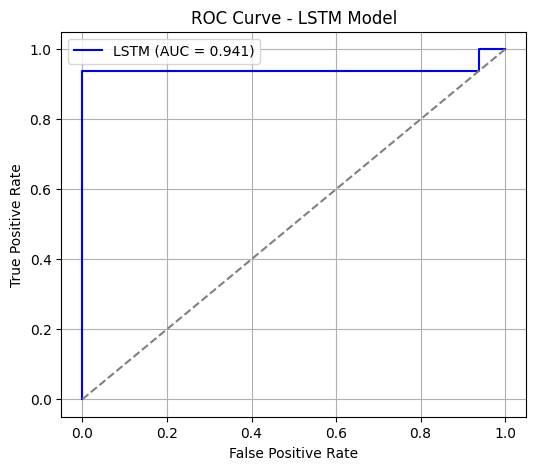

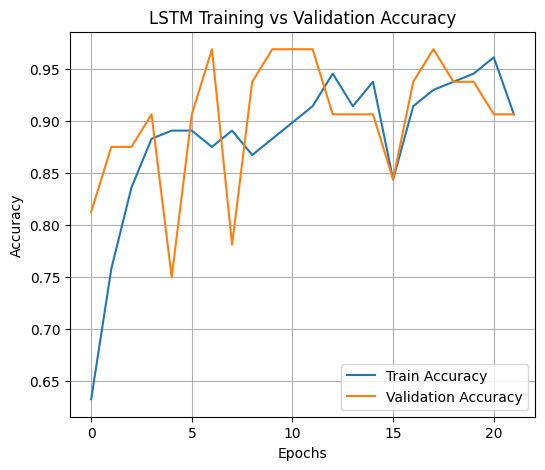

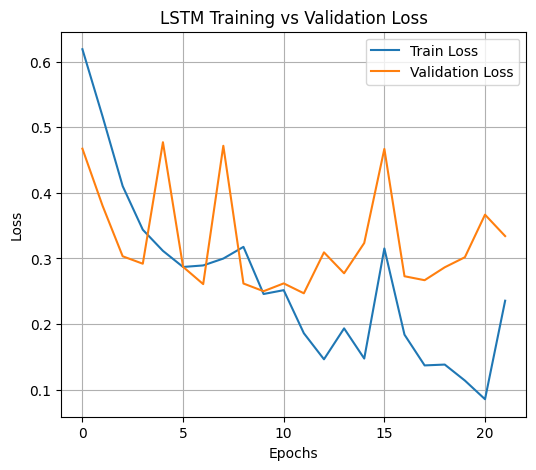

In [ ]:
# 1) LSTM MODEL WITH AUC, ROC, ACCURACY & LOSS CURVES
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
# Build LSTM Model
def build_lstm_model(num_classes=2):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(NUM_FRAMES, FRAME_FEATURE_SIZE)),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# Initialize and train model
lstm_model = build_lstm_model(len(np.unique(y_all)))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_seq_train, y_train,
    validation_data=(X_seq_test, y_test),
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
# Predictions
y_pred_proba = lstm_model.predict(X_seq_test)
lstm_preds = np.argmax(y_pred_proba, axis=1)

# Metrics
print("LSTM Confusion Matrix:\n", confusion_matrix(y_test, lstm_preds))
print("LSTM Classification Report:\n", classification_report(y_test, lstm_preds))
print("Accuracy:", accuracy_score(y_test, lstm_preds))

# ---------------------------
# AUC and ROC Curve
# ---------------------------
# Works for binary classification
if len(np.unique(y_test)) == 2:
    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])

    print("AUC Score:", auc_score)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'LSTM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title('ROC Curve - LSTM Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    # Multi-class AUC
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    print("Multi-class AUC Score:", auc_score)

# Accuracy and Loss Curves
plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Save the Model
lstm_model.save("lstm_fall_model_with_paf.h5")


In [ ]:
# ============================
# 2) XGBOOST MODEL
# ============================
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6,
                          subsample=0.8, colsample_bytree=0.8, random_state=42,
                          use_label_encoder=False, eval_metric="mlogloss")
xgb_model.fit(X_flat_train, y_train)
y_pred_xgb = xgb_model.predict(X_flat_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
joblib.dump(xgb_model, "xgb_fall_model_with_paf.pkl")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:38:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91        16
           1       0.93      0.88      0.90        16

    accuracy                           0.91        32
   macro avg       0.91      0.91      0.91        32
weighted avg       0.91      0.91      0.91        32

XGBoost Confusion Matrix:
 [[15  1]
 [ 2 14]]


['xgb_fall_model_with_paf.pkl']

In [ ]:
# ============================
# 3) SVM MODEL
# ============================
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_flat_train, y_train)
y_pred_svm = svm_model.predict(X_flat_test)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
joblib.dump(svm_model, "svm_fall_model_with_paf.pkl")

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        16
           1       1.00      0.88      0.93        16

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32

SVM Confusion Matrix:
 [[16  0]
 [ 2 14]]


['svm_fall_model_with_paf.pkl']

In [ ]:
# ============================
# 4) ANN MODEL
# ============================
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_flat_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_all)), activation='softmax')
])
ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_ann = ann_model.fit(X_flat_train, y_train,
                            validation_split=0.2, epochs=50, batch_size=16, verbose=1)
y_pred_ann = np.argmax(ann_model.predict(X_flat_test), axis=1)
print("ANN Classification Report:\n", classification_report(y_test, y_pred_ann))
print("ANN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
ann_model.save("ann_fall_model_with_paf.h5")




/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.5387 - loss: 1.4197 - val_accuracy: 0.6538 - val_loss: 0.8219
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4671 - loss: 2.0922 - val_accuracy: 0.8462 - val_loss: 0.4801
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5459 - loss: 1.4475 - val_accuracy: 0.6923 - val_loss: 0.5802
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5607 - loss: 1.2222 - val_accuracy: 0.6154 - val_loss: 0.5847
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7123 - loss: 0.6794 - val_accuracy: 0.8846 - val_loss: 0.3073
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8162 - loss: 0.3957 - val_accuracy: 0.8846 - val_loss: 0.2749
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7736 - loss: 0.7182 - val_accuracy: 0.7308 - val_loss: 0.4342
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7553 - loss: 0.6544 - val_accuracy: 0.8846 - val_loss: 0.3018


ANN Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.94      0.86        16
           1       0.92      0.75      0.83        16

    accuracy                           0.84        32
   macro avg       0.86      0.84      0.84        32
weighted avg       0.86      0.84      0.84        32

ANN Confusion Matrix:
 [[15  1]
 [ 4 12]]


In [ ]:
# ============================================
# test_svm_fall_detection.py
# ============================================
import joblib
import numpy as np
import cv2
import mediapipe as mp

# ------------------------------
# Parameters (must match training)
# ------------------------------
NUM_FRAMES = 30
MP_LM_COUNT = 33
LANDMARK_FEATURES = 4

mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

LIMB_PAIRS = list(mp_pose.POSE_CONNECTIONS)
PAF_FEATURES_PER_LIMB = 4
NUM_LIMBS = len(LIMB_PAIRS)
BASE_FEATURE_SIZE = MP_LM_COUNT * LANDMARK_FEATURES
PAF_FEATURE_SIZE = NUM_LIMBS * PAF_FEATURES_PER_LIMB
FRAME_FEATURE_SIZE = BASE_FEATURE_SIZE + PAF_FEATURE_SIZE

label_map = {0: "ADL", 1: "Fall"}

# ------------------------------
# Feature computation functions
# ------------------------------
def compute_paf_features_from_landmarks(landmarks):
    lm = np.array(landmarks).reshape(MP_LM_COUNT, LANDMARK_FEATURES)
    paf_feats = []
    for (a, b) in LIMB_PAIRS:
        if a >= MP_LM_COUNT or b >= MP_LM_COUNT:
            paf_feats.extend([0.0]*4)
            continue
        xa, ya, za, va = lm[a]
        xb, yb, zb, vb = lm[b]
        conf = float(va)*float(vb)
        if conf == 0 or (xa==0 and ya==0 and xb==0 and yb==0):
            paf_feats.extend([0.0]*4)
            continue
        dx = float(xb) - float(xa)
        dy = float(yb) - float(ya)
        length = float(np.sqrt(dx*dx + dy*dy))
        paf_feats.extend([dx, dy, length, conf])
    return paf_feats


def extract_pose_keypoints_with_paf(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        zero_frame = [0.0]*FRAME_FEATURE_SIZE
        return np.vstack([zero_frame]*num_frames)
    step = max(1, total_frames // num_frames)
    frame_features = []
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)
        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            landmarks = [0.0]*BASE_FEATURE_SIZE
        paf_feats = compute_paf_features_from_landmarks(landmarks)
        combined = landmarks + paf_feats
        frame_features.append(combined)
        if len(frame_features) == num_frames:
            break
    cap.release()
    while len(frame_features) < num_frames:
        frame_features.append([0.0]*FRAME_FEATURE_SIZE)
    return np.array(frame_features)

# ------------------------------
# Load the trained SVM model
# ------------------------------
svm_model = joblib.load("svm_fall_model_with_paf.pkl")

# ------------------------------
# Prediction function
# ------------------------------
def predict_fall(video_path):
    print(f"\nProcessing: {video_path}")
    seq = extract_pose_keypoints_with_paf(video_path)
    flat = seq.flatten().reshape(1, -1)
    pred = svm_model.predict(flat)[0]
    print(f"Prediction: {label_map[pred]}")
    return pred

# ------------------------------
# Test on your two videos
# ------------------------------
fall_video = "/content/drive/MyDrive/video_1/fall 3.mp4.mp4"
adl_video = "/content/drive/MyDrive/video_1/test adl.mp4"

predict_fall(fall_video)
predict_fall(adl_video)


Processing: /content/drive/MyDrive/video_1/fall 3.mp4.mp4
Prediction: Fall

Processing: /content/drive/MyDrive/video_1/test adl.mp4
Prediction: ADL


0

In [ ]:
import joblib
import numpy as np
import cv2
import mediapipe as mp
from collections import deque

# ------------------------------
# Parameters
# ------------------------------
NUM_FRAMES = 30  # Number of frames for prediction window
MP_LM_COUNT = 33
LANDMARK_FEATURES = 4

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# PAF Configuration
LIMB_PAIRS = list(mp_pose.POSE_CONNECTIONS)
NUM_LIMBS = len(LIMB_PAIRS)
PAF_FEATURES_PER_LIMB = 4
BASE_FEATURE_SIZE = MP_LM_COUNT * LANDMARK_FEATURES
PAF_FEATURE_SIZE = NUM_LIMBS * PAF_FEATURES_PER_LIMB
FRAME_FEATURE_SIZE = BASE_FEATURE_SIZE + PAF_FEATURE_SIZE

label_map = {0: "ADL", 1: "Fall"}

# ------------------------------
# Feature Computation
# ------------------------------
def compute_paf_features_from_landmarks(landmarks):
    """Compute PAF (Part Affinity Field) features from pose landmarks"""
    lm = np.array(landmarks).reshape(MP_LM_COUNT, LANDMARK_FEATURES)
    paf_feats = []

    for (a, b) in LIMB_PAIRS:
        if a >= MP_LM_COUNT or b >= MP_LM_COUNT:
            paf_feats.extend([0.0] * 4)
            continue

        xa, ya, za, va = lm[a]
        xb, yb, zb, vb = lm[b]
        conf = float(va) * float(vb)

        if conf == 0 or (xa == 0 and ya == 0 and xb == 0 and yb == 0):
            paf_feats.extend([0.0] * 4)
            continue

        dx = float(xb) - float(xa)
        dy = float(yb) - float(ya)
        length = float(np.sqrt(dx*dx + dy*dy))
        paf_feats.extend([dx, dy, length, conf])

    return paf_feats


def extract_features_from_frame(frame):
    """Extract pose landmarks and PAF features from a single frame"""
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])

        paf_feats = compute_paf_features_from_landmarks(landmarks)
        combined = landmarks + paf_feats
        return combined, results.pose_landmarks
    else:
        zero_features = [0.0] * FRAME_FEATURE_SIZE
        return zero_features, None


def get_person_bbox(pose_landmarks, frame_width, frame_height, padding=20):
    """Calculate bounding box around the detected person"""
    if not pose_landmarks:
        return None

    x_coords = [lm.x * frame_width for lm in pose_landmarks.landmark]
    y_coords = [lm.y * frame_height for lm in pose_landmarks.landmark]

    x_min = max(0, int(min(x_coords)) - padding)
    y_min = max(0, int(min(y_coords)) - padding)
    x_max = min(frame_width, int(max(x_coords)) + padding)
    y_max = min(frame_height, int(max(y_coords)) + padding)

    return (x_min, y_min, x_max, y_max)


# ------------------------------
# Load Trained Model
# ------------------------------
print("Loading trained SVM model...")
svm_model = joblib.load("svm_fall_model_with_paf.pkl")
print("Model loaded successfully!")


# ------------------------------
# Real-time Fall Detection
# ------------------------------
def detect_fall_realtime(video_path, output_path=None):
    """
    Process video and detect falls in real-time with bounding boxes

    Args:
        video_path: Path to input video
        output_path: Optional path to save output video
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS)) or 30
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"\nProcessing video: {video_path}")
    print(f"Resolution: {width}x{height}, FPS: {fps}, Total frames: {total_frames}")

    # Setup video writer if output path is provided
    out = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Buffer to store recent frames' features for sliding window prediction
    frame_buffer = deque(maxlen=NUM_FRAMES)

    # Initialize with zeros
    for _ in range(NUM_FRAMES):
        frame_buffer.append([0.0] * FRAME_FEATURE_SIZE)

    frame_count = 0
    current_prediction = "Initializing..."

    try:
        # Check if running in Colab
        try:
            from google.colab.patches import cv2_imshow
            is_colab = True
        except ImportError:
            is_colab = False

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1

            # Extract features from current frame
            features, pose_landmarks = extract_features_from_frame(frame)
            frame_buffer.append(features)

            # Make prediction using sliding window of frames
            if frame_count >= NUM_FRAMES:
                feature_sequence = np.array(list(frame_buffer))
                flat_features = feature_sequence.flatten().reshape(1, -1)
                pred = svm_model.predict(flat_features)[0]
                current_prediction = label_map[pred]

            # Determine color based on prediction
            if current_prediction == "Fall":
                color = (0, 0, 255)  # Red for Fall
                bg_color = (0, 0, 180)
            elif current_prediction == "ADL":
                color = (0, 255, 0)  # Green for ADL
                bg_color = (0, 180, 0)
            else:
                color = (255, 255, 255)  # White for Initializing
                bg_color = (128, 128, 128)

            # Draw bounding box around person if detected
            if pose_landmarks:
                bbox = get_person_bbox(pose_landmarks, width, height)
                if bbox:
                    x_min, y_min, x_max, y_max = bbox
                    cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 3)

                    # Draw label background
                    label_text = f"{current_prediction}"
                    (text_width, text_height), baseline = cv2.getTextSize(
                        label_text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3
                    )
                    cv2.rectangle(
                        frame,
                        (x_min, y_min - text_height - 20),
                        (x_min + text_width + 10, y_min),
                        bg_color,
                        -1
                    )

                    # Draw label text
                    cv2.putText(
                        frame,
                        label_text,
                        (x_min + 5, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1.2,
                        (255, 255, 255),
                        3
                    )

                # Optionally draw pose landmarks
                mp_drawing.draw_landmarks(
                    frame,
                    pose_landmarks,
                    mp_pose.POSE_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(0, 255, 255), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(255, 0, 255), thickness=2)
                )

            # Draw frame counter
            cv2.putText(
                frame,
                f"Frame: {frame_count}/{total_frames}",
                (20, height - 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 255, 255),
                2
            )

            # Write frame to output video
            if out:
                out.write(frame)

            # Display frame
            if is_colab:
                # In Colab, show every 10th frame to avoid flooding output
                if frame_count % 10 == 0:
                    cv2_imshow(frame)
            else:
                cv2.imshow('Fall Detection', frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    print("\nStopped by user")
                    break

            # Progress indicator
            if frame_count % 30 == 0:
                print(f"Processed {frame_count}/{total_frames} frames - Current: {current_prediction}")

    finally:
        cap.release()
        if out:
            out.release()
        if not is_colab:
            cv2.destroyAllWindows()

        print(f"\n✅ Processing complete!")
        print(f"Total frames processed: {frame_count}")
        if output_path:
            print(f"Output saved to: {output_path}")


# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    # Test videos
    fall_video = "/content/drive/MyDrive/Human Fall Detection Sample.mp4"
    adl_video = "/content/drive/MyDrive/video_1/test adl.mp4"

    print("="*60)
    print("FALL DETECTION SYSTEM - Real-time Processing")
    print("="*60)

    # Process fall video
    print("\n[1/2] Processing FALL video...")
    detect_fall_realtime(
        video_path=fall_video,
        output_path="fall_video_output.mp4"
    )

    print("\n" + "="*60)

    # Process ADL video
    print("\n[2/2] Processing ADL video...")
    detect_fall_realtime(
        video_path=adl_video,
        output_path="adl_video_output.mp4"
    )

    print("\n" + "="*60)
    print(" All videos processed successfully!")
    print("="*60)

###PAF

In [ ]:
import numpy as np
import mediapipe as mp
import cv2

# Parameters
NUM_FRAMES = 30
MP_LM_COUNT = 33
LANDMARK_FEATURES = 4  # x, y, z, visibility
BASE_FEATURE_SIZE = MP_LM_COUNT * LANDMARK_FEATURES  # 132

# MediaPipe Pose setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

# Build limb pairs (connections)
LIMB_PAIRS = list(mp_pose.POSE_CONNECTIONS)  # tuples of (a, b)
NUM_LIMBS = len(LIMB_PAIRS)
PAF_FEATURES_PER_LIMB = 4  # dx, dy, length, confidence(product of vis)
PAF_FEATURE_SIZE = NUM_LIMBS * PAF_FEATURES_PER_LIMB

# Combined frame feature size (landmarks + PAF)
FRAME_FEATURE_SIZE = BASE_FEATURE_SIZE + PAF_FEATURE_SIZE

print(f"Num limbs: {NUM_LIMBS}, PAF features/frame: {PAF_FEATURE_SIZE}, frame feature size: {FRAME_FEATURE_SIZE}")

# Helper Compute PAF features per frame
def compute_paf_features_from_landmarks(landmarks):
    """
    landmarks: list or array of length 33*4 (or shape (33,4))
    returns: list of length NUM_LIMBS * 4 -> [dx, dy, length, conf] for each limb
    """
    lm = np.array(landmarks).reshape(MP_LM_COUNT, LANDMARK_FEATURES)
    paf_feats = []
    for (a, b) in LIMB_PAIRS:
        if a >= MP_LM_COUNT or b >= MP_LM_COUNT:
            paf_feats.extend([0.0, 0.0, 0.0, 0.0])
            continue

        xa, ya, za, va = lm[a]
        xb, yb, zb, vb = lm[b]

        conf = float(va) * float(vb)
        if conf == 0 or (xa == 0 and ya == 0 and xb == 0 and yb == 0):
            paf_feats.extend([0.0, 0.0, 0.0, 0.0])
            continue

        dx = float(xb) - float(xa)
        dy = float(yb) - float(ya)
        length = float(np.sqrt(dx * dx + dy * dy))

        paf_feats.extend([dx, dy, length, conf])

    return paf_feats

# Extract pose keypoints with PAF from a video
def extract_pose_keypoints_with_paf(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        zero_frame = [0.0] * FRAME_FEATURE_SIZE
        return np.vstack([zero_frame] * num_frames)

    step = max(1, total_frames // num_frames)
    frame_features = []

    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            landmarks = []
            for lm in results.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])
        else:
            landmarks = [0.0] * BASE_FEATURE_SIZE

        paf_feats = compute_paf_features_from_landmarks(landmarks)
        combined = landmarks + paf_feats
        frame_features.append(combined)

        if len(frame_features) == num_frames:
            break

    cap.release()
    while len(frame_features) < num_frames:
        frame_features.append([0.0] * FRAME_FEATURE_SIZE)

    return np.array(frame_features)


Num limbs: 35, PAF features/frame: 140, frame feature size: 272


In [ ]:

# Load data
X_pose, y_pose = load_all_subjects_pose()

print("Dataset shape:", X_pose.shape)  # (num_videos, NUM_FRAMES, 132)
print("Labels shape:", y_pose.shape)



Processing Subject 1...
Processing Subject 2...
Processing Subject 3...
Processing Subject 4...
Dataset shape: (160, 30, 132)
Labels shape: (160,)


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split # Assuming this is where train_test_split comes from



#  Model Definition and Training
print(" Training LSTM Model ")
lstm = Sequential([
    # Masking is essential for handling variable-length padded sequences
    Masking(mask_value=0.0, input_shape=(NUM_FRAMES, FEATURE_SIZE)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64), # This layer returns the final sequence context for classification
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax') # Output layer for 2 classes (e.g., ADL and Fall)
])

lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = lstm.fit(
    X_train_seq,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[es],
    verbose=1
)
lstm.save("lstm_pose_model.h5")
print(" Saved LSTM model to lstm_pose_model.h5")

#  Prediction and Evaluation

# 1. Get probability scores from the model
y_prob_lstm = lstm.predict(X_test_seq)

# 2. Convert probability scores to discrete class labels
y_pred_lstm = np.argmax(y_prob_lstm, axis=1)

# 3. Generate Evaluation Metrics
print("\n-Model Evaluation (Test Set) ")
print("**LSTM Confusion Matrix:**\n", confusion_matrix(y_test, y_pred_lstm))
print("\n**LSTM Classification Report:**\n", classification_report(y_test, y_pred_lstm))

 Training LSTM Model 
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.3864 - loss: 0.7361 - val_accuracy: 0.8077 - val_loss: 0.6086
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6237 - loss: 0.6337 - val_accuracy: 0.8077 - val_loss: 0.4832
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7669 - loss: 0.4889 - val_accuracy: 0.8846 - val_loss: 0.4249
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8571 - loss: 0.4615 - val_accuracy: 0.6923 - val_loss: 0.6273
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7436 - loss: 0.5284 - val_accuracy: 0.8462 - val_loss: 0.3824
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7740 - loss: 0.4245 - val_accuracy: 0.8462 - val_loss: 0.3788
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8856 - loss: 0.3611 - val_accuracy: 0.8077 - val_loss: 0.3949
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8282 - loss: 0.4084 - val_accuracy: 0.8077 - val_loss: 0.4340
Epoch 9/50

 Saved LSTM model to lstm_pose_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step

-Model Evaluation (Test Set) 
**LSTM Confusion Matrix:**
 [[13  2]
 [ 1 16]]

**LSTM Classification Report:**
               precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.89      0.94      0.91        17

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.91        32
weighted avg       0.91      0.91      0.91        32



In [ ]:
y_pred = np.argmax(model.predict(X_pose), axis=1)
print(confusion_matrix(y_pose, y_pred))
print(classification_report(y_pose, y_pred))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[78  3]
 [ 7 72]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        81
           1       0.96      0.91      0.94        79

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("SVM Report:\n", classification_report(y_test, y_pred))
joblib.dump(svm, "svm_pose_model.pkl")


SVM Confusion Matrix:
 [[14  1]
 [ 1 16]]
SVM Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.94      0.94      0.94        17

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



['svm_pose_model.pkl']

In [ ]:
import numpy as np
from xgboost import XGBClassifier
import joblib
from sklearn.metrics import classification_report, confusion_matrix


#  Model Definition and Training
print("Training XGBoost Model ")
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,  # Suppress the deprecation warning
    eval_metric='mlogloss'
)

xgb.fit(X_train, y_train)
joblib.dump(xgb, "xgb_pose_model.pkl")
print("Saved XGBoost model to xgb_pose_model.pkl")

# Prediction and Evaluation

# 1. Get predictions on the test set
y_pred_xgb = xgb.predict(X_test)

# 2. Generate Evaluation Metrics
print("\nModel Evaluation (Test Set) ")
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

Training XGBoost Model 


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [17:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved XGBoost model to xgb_pose_model.pkl

Model Evaluation (Test Set) 
XGBoost Confusion Matrix:
 [[14  1]
 [ 1 16]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.94      0.94      0.94        17

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5682 - loss: 1.2515 - val_accuracy: 0.6923 - val_loss: 0.5637
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6121 - loss: 0.9519 - val_accuracy: 0.6154 - val_loss: 0.7002
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6047 - loss: 0.9836 - val_accuracy: 0.4615 - val_loss: 1.1668
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6334 - loss: 0.9896 - val_accuracy: 0.6923 - val_loss: 0.5471
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6516 - loss: 0.7270 - val_accuracy: 0.5000 - val_loss: 1.0221
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7201 - loss: 0.7892 - val_accuracy: 0.8462 - val_loss: 0.5103
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7450 - loss: 0.5219 - val_accuracy: 0.6923 - val_loss: 0.5430
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7587 - loss: 0.4941 - val_accuracy: 0.6923 - val_loss: 0.4711


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

ANN Evaluation 
Confusion Matrix:
 [[15  0]
 [ 2 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       1.00      0.88      0.94        17

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



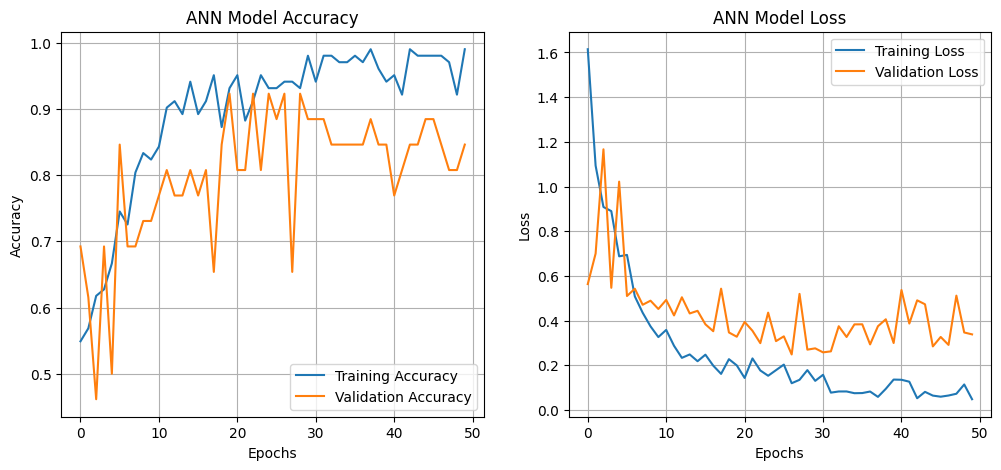

In [ ]:
# ANN MODEL without EarlyStopping + Accuracy & Loss Graphs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Build ANN model
ann_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_pose)), activation='softmax')
])

ann_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model (no EarlyStopping)
history_ann = ann_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Evaluate model
y_pred = np.argmax(ann_model.predict(X_test), axis=1)

print("\nANN Evaluation ")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12,5))

# Accuracy Plot
plt.subplot(1,2,1)
plt.plot(history_ann.history['accuracy'], label='Training Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1,2,2)
plt.plot(history_ann.history['loss'], label='Training Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()
